### Configure the Model

In [24]:
from dotenv import load_dotenv
from langchain_groq  import ChatGroq

load_dotenv()
import os
os.environ['GROQ_API_KEY'] = os.getenv("GROQ_API_KEY")

model = ChatGroq(model="deepseek-r1-distill-llama-70b")
model.invoke("hi how are you")

AIMessage(content="<think>\n\n</think>\n\nHello! I'm just a virtual assistant, so I don't have feelings, but I'm here and ready to help you with whatever you need. How are you doing? 😊", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 42, 'prompt_tokens': 7, 'total_tokens': 49, 'completion_time': 0.206461199, 'prompt_time': 0.000141348, 'queue_time': 0.056942642, 'total_time': 0.206602547}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'stop', 'logprobs': None}, id='run--d614f9fa-2def-4fdd-9753-22fc3e13e511-0', usage_metadata={'input_tokens': 7, 'output_tokens': 42, 'total_tokens': 49})

In [25]:
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph,MessagesState,START,END
from langgraph.prebuilt import ToolNode

def call_model(state: MessagesState):
    messages = state["messages"]
    response = model.invoke(messages)
    return {"messages": [response]}

In [26]:
state={"messages":["hi hello how are you?"]}
call_model(state)

{'messages': [AIMessage(content="<think>\n\n</think>\n\nHello! I'm just a virtual assistant, so I don't have feelings, but I'm here and ready to help you with whatever you need. How are *you* doing? 😊", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 44, 'prompt_tokens': 9, 'total_tokens': 53, 'completion_time': 0.204291748, 'prompt_time': 0.00446428, 'queue_time': 0.05737218, 'total_time': 0.208756028}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'stop', 'logprobs': None}, id='run--381f9e84-5fc7-4ebe-9e7c-ed002dc224cf-0', usage_metadata={'input_tokens': 9, 'output_tokens': 44, 'total_tokens': 53})]}

### Creating a Simple workflow without tool calling

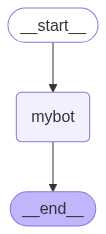

In [27]:
workflow = StateGraph(MessagesState)
workflow.add_node("mybot", call_model)
workflow.set_entry_point("mybot")
workflow.set_finish_point("mybot")
app = workflow.compile()

# code to display graph
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [28]:
input={"messages":["hi hello how are you?"]}
app.invoke(input)

{'messages': [HumanMessage(content='hi hello how are you?', additional_kwargs={}, response_metadata={}, id='8a3041ee-c4b9-4c2c-8c8a-833c4e0df493'),
  AIMessage(content="<think>\n\n</think>\n\nHello! I'm just a virtual assistant, so I don't have feelings, but I'm here and ready to help you with whatever you need. How are *you* doing? 😊", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 44, 'prompt_tokens': 9, 'total_tokens': 53, 'completion_time': 0.208219107, 'prompt_time': 0.001028351, 'queue_time': 0.055764798000000004, 'total_time': 0.209247458}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'stop', 'logprobs': None}, id='run--dc778aeb-e1e8-42f5-86dd-5dc48b563ca8-0', usage_metadata={'input_tokens': 9, 'output_tokens': 44, 'total_tokens': 53})]}

In [29]:
for output in app.stream(input):
    for key,value in output.items():
        print(f"Output from {key} Node")
        print("_______")
        print(value)
        print("\n")

Output from mybot Node
_______
{'messages': [AIMessage(content="<think>\n\n</think>\n\nHello! I'm just a virtual assistant, so I don't have feelings, but I'm here and ready to help you. How are you doing? 😊", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 38, 'prompt_tokens': 9, 'total_tokens': 47, 'completion_time': 0.198852636, 'prompt_time': 0.000478332, 'queue_time': 0.056778328, 'total_time': 0.199330968}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'stop', 'logprobs': None}, id='run--baeac65e-2a72-4772-8ab4-40fde98c79fa-0', usage_metadata={'input_tokens': 9, 'output_tokens': 38, 'total_tokens': 47})]}




### Workflow with Tool calling

In [30]:
@tool
def weather_tool(query:str):
    '''This is a custom tool for getting weather and temperature information'''
    if "delhi" in query.lower():
        return "the temp is 45 degree and sunny"
    return "the temp is 25 degree and cloudy"

weather_tool.invoke("what is the weather in delhi")

'the temp is 45 degree and sunny'

### Binding the tool to LLM

In [38]:
tools = [weather_tool]
llm_with_tool = model.bind_tools(tools)

response=llm_with_tool.invoke("what is the temp is delhi?")
response

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '4z0x5bx7m', 'function': {'arguments': '{"query":"Delhi temperature"}', 'name': 'weather_tool'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 257, 'prompt_tokens': 136, 'total_tokens': 393, 'completion_time': 2.736082437, 'prompt_time': 0.010099738, 'queue_time': 0.052240852000000004, 'total_time': 2.746182175}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--7d21a2b9-11c1-4d3c-927d-4461b79827eb-0', tool_calls=[{'name': 'weather_tool', 'args': {'query': 'Delhi temperature'}, 'id': '4z0x5bx7m', 'type': 'tool_call'}], usage_metadata={'input_tokens': 136, 'output_tokens': 257, 'total_tokens': 393})

In [39]:
response.tool_calls

[{'name': 'weather_tool',
  'args': {'query': 'Delhi temperature'},
  'id': '4z0x5bx7m',
  'type': 'tool_call'}]

In [40]:
def weather_tool_with_llm(state:MessagesState):
    question=state["messages"]
    response=llm_with_tool.invoke(question)
    return {"messages":[response]}

input={"messages":["what is the temp is delhi?"]}
response=weather_tool_with_llm(input)
print(response["messages"][-1].content)
print(response["messages"][-1].tool_calls)


[{'name': 'weather_tool', 'args': {'query': 'delhi temperature'}, 'id': '7ww2n9nsg', 'type': 'tool_call'}]


### Router Function

In [41]:
def router_function(state:MessagesState):
    messages = state["messages"][-1]
    if messages.tool_calls:
        return "tools"
    return END

In [42]:
tools

[StructuredTool(name='weather_tool', description='This is a custom tool for getting weather and temperature information', args_schema=<class 'langchain_core.utils.pydantic.weather_tool'>, func=<function weather_tool at 0x000001CFA672C0E0>)]

### Creating ToolNode

In [43]:
tool_node = ToolNode(tools)

### Creating Workflow with Tool

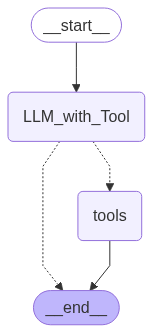

In [45]:
workflow = StateGraph(MessagesState)
workflow.add_node("LLM_with_Tool", weather_tool_with_llm)
workflow.add_node("tools",tool_node)
workflow.set_entry_point("LLM_with_Tool")
workflow.add_conditional_edges("LLM_with_Tool", router_function, {"tools":"tools",END:END})
app = workflow.compile()

from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

### Checking Output from workflow

In [48]:
response=app.invoke({"messages":["what is a weather in bengraluru?"]})
response

{'messages': [HumanMessage(content='what is a weather in bengraluru?', additional_kwargs={}, response_metadata={}, id='c67cde0f-f87e-4008-83b1-b5ef9226730b'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '6bp6vrq70', 'function': {'arguments': '{"query":"Bengaluru"}', 'name': 'weather_tool'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 132, 'prompt_tokens': 138, 'total_tokens': 270, 'completion_time': 0.585568607, 'prompt_time': 0.008798102, 'queue_time': 0.056687478, 'total_time': 0.594366709}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--fc10d752-d52f-4bec-b46f-5175dc56c144-0', tool_calls=[{'name': 'weather_tool', 'args': {'query': 'Bengaluru'}, 'id': '6bp6vrq70', 'type': 'tool_call'}], usage_metadata={'input_tokens': 138, 'output_tokens': 132, 'total_tokens': 270}),
  ToolMessage(content='the temp is 25 degree and cloudy', name='we

In [49]:
response["messages"][-1].content

'the temp is 25 degree and cloudy'

In [54]:
res = app.invoke({"messages":["what is a weather in delhi?"]})
res["messages"][-1].content

'the temp is 45 degree and sunny'

In [57]:
result = app.invoke({"messages":["hi how are you?"]})
result["messages"][-1].content

"Hello! I'm just a virtual assistant, so I don't have feelings, but I'm here and ready to help you with whatever you need. How can I assist you today?"

### Creating a looping edge from tool to LLM call

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


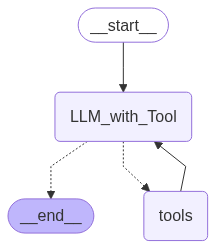

In [68]:
workflow.add_edge("tools","LLM_with_Tool")
app2=workflow.compile()

from IPython.display import Image, display
display(Image(app2.get_graph().draw_mermaid_png()))

In [67]:
for output in app2.stream({"messages":["what is a weather in new delhi?"]}):
    for key,value in output.items():
        print(f"here is output from {key}")
        print("_______")
        print(value)
        print("\n")

here is output from LLM_with_Tool
_______
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'yxdmhxgdv', 'function': {'arguments': '{"query":"New Delhi"}', 'name': 'weather_tool'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 166, 'prompt_tokens': 137, 'total_tokens': 303, 'completion_time': 0.678175683, 'prompt_time': 0.008853151, 'queue_time': 0.052611508, 'total_time': 0.687028834}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--af6be495-07c4-4551-b3ae-2fbb0b9aed06-0', tool_calls=[{'name': 'weather_tool', 'args': {'query': 'New Delhi'}, 'id': 'yxdmhxgdv', 'type': 'tool_call'}], usage_metadata={'input_tokens': 137, 'output_tokens': 166, 'total_tokens': 303})]}


here is output from tools
_______
{'messages': [ToolMessage(content='the temp is 45 degree and sunny', name='weather_tool', id='b4ac8613-c2ae-4ea2-93f0-76c83878746e', t

### Adding Memory to the Workflow

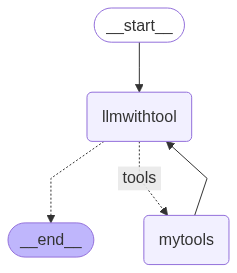

In [73]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

workflow3=StateGraph(MessagesState)
workflow3.add_node("llmwithtool",weather_tool_with_llm)
workflow3.add_node("mytools",tool_node)
workflow3.add_edge(START,"llmwithtool")
workflow3.add_conditional_edges("llmwithtool",
                                router_function,
                                {"tools":"mytools",
                                 END:END})
workflow3.add_edge("mytools","llmwithtool")
app4=workflow3.compile(checkpointer=memory)

from IPython.display import Image, display
display(Image(app4.get_graph().draw_mermaid_png()))

In [74]:
config = {"configurable": {"thread_id": 1}}
events=app4.stream(
    {"messages":["what is a weather in new delhi?"]},config=config,stream_mode="values"
    )

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

what is a weather in new delhi?
================================== Ai Message ==================================
Tool Calls:
  weather_tool (h7y2qwt2p)
 Call ID: h7y2qwt2p
  Args:
    query: New Delhi
================================= Tool Message =================================
Name: weather_tool

the temp is 45 degree and sunny
================================== Ai Message ==================================

The weather in New Delhi is 45 degrees and sunny. 🌞


In [75]:
events=app4.stream(
    {"messages":["what is a weather in indore?"]},config=config,stream_mode="values"
    )

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

what is a weather in indore?
================================== Ai Message ==================================
Tool Calls:
  weather_tool (p1ybyef1v)
 Call ID: p1ybyef1v
  Args:
    query: Indore
================================= Tool Message =================================
Name: weather_tool

the temp is 25 degree and cloudy
================================== Ai Message ==================================
Tool Calls:
  weather_tool (2002908j2)
 Call ID: 2002908j2
  Args:
    query: Indore
================================= Tool Message =================================
Name: weather_tool

the temp is 25 degree and cloudy
================================== Ai Message ==================================

The weather in Indore is 25 degrees and cloudy. ☁️


In [77]:
config

{'configurable': {'thread_id': 1}}

In [84]:
memory.get(config)

In [ ]:
## based on memory it is able to ans question

events=app4.stream(
    {"messages":["in which city the temp was 25 degree?"]},config=config,stream_mode="values"
    )

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

in which city the temp was 25 degree?
================================== Ai Message ==================================

The city where the temperature was 25 degrees is **Indore**.
